# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

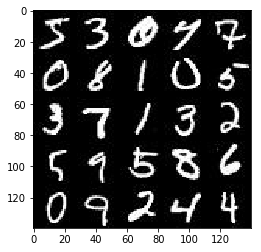

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

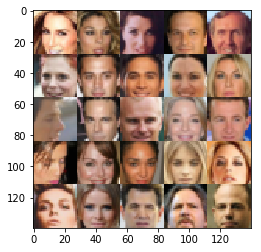

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # DONE: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "c:\\users\\peter\\anaconda3\\envs\\tflearn-gpu\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "c:\\users\\peter\\anaconda3\\envs\\tflearn-gpu\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "c:\\users\\peter\\anaconda3\\envs\\tflearn-gpu\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "c:\\users\\peter\\anaconda3\\envs\\tflearn-gpu\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "c:\\users\\peter\\anaconda3\\envs\\tflearn-gpu\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instan

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # DONE: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28 x 28 x out_channel_dim
        #print(images.get_shape().as_list())
        
        # conv to 14, 14, 128
        x = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        # conv to 7, 7, 256
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding='same', use_bias=False)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        # conv to 4, 4, 512
        x = tf.layers.conv2d(x, 512, 5, strides=2, padding='same', use_bias=False)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        # flatten
        x = tf.reshape(x, (-1, 4*4*512))
        #print(x.get_shape().as_list())
        
        # logits and output
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)
        
        
        return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.02): # I put alpha parameter to this function call
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # DONE: Implement Function
    
    # auxiliar variables
    reuse = not is_train
    
    # scope for generator
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z, 4*4*512)
        #print(x.get_shape().as_list())
        
        # batch normalization to 4x4x512
        x = tf.reshape(x, (-1, 4, 4, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        
        # conv to 7x7x256
        x = tf.layers.conv2d_transpose(x, 256, 4, strides=1, padding='valid')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
            
        # conv to 14x14x128        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        # Output layer, 28 x 28 x out_channel_dim (3 or 1, depending on the task - faces or minst)
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same')
        #print(logits.get_shape().as_list())
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
smooth = 0.1

def model_loss(input_real, input_z, out_channel_dim, alpha=0.02): # I put alpha parameter to this function call
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # DONE: Implement Function
    
    # Just for reference:
    #   discriminator(images, reuse=False, alpha=0.01)
    #   generator(z, out_channel_dim, is_train=True, alpha=0.02): # I put alpha parameter to this function call
    
    g_out = generator(input_z, out_channel_dim, alpha=alpha)
    d_out_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                        logits=d_logits_real,
                                                        labels=tf.ones_like(d_out_real) * (1. - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                        logits=d_logits_fake,
                                                        labels=tf.zeros_like(d_out_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                        logits=d_logits_fake,
                                                        labels=tf.ones_like(d_out_fake)))

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # DONE: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
from datetime import datetime

print_every = 10
show_every = 100
n_images = 16

#class GAN:
#    def __init__(self, data_shape, z_size, learning_rate, alpha=0.02, beta1=0.5):
#        tf.reset_default_graph()
#        
#        # Only for reference:
#        #   model_inputs(image_width, image_height, image_channels, z_dim) -> inputs_real, inputs_z, lr
#        #   model_loss(input_real, input_z, out_channel_dim, alpha=0.02) -> d_loss, g_loss
#        #   model_opt(d_loss, g_loss, learning_rate, beta1) -> d_train_opt, g_train_opt
#
#        self.input_real, self.input_z, self.learning_rate = model_inputs(*data_shape[1:], z_dim)
#
#        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, data_shape[-1], alpha=0.02)
#        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)


def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # DONE: Build Model
    # Create the network
    #net = GAN(data_shape, z_dim, learning_rate, beta1=beta1)
    tf.reset_default_graph()

    minput_real, minput_z, mlearning_rate = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(minput_real, minput_z, data_shape[-1], alpha=0.02)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    
    # Auxiliar variables
    steps = 0
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1
    sample_z = np.random.uniform(-1, 1, size=(n_images, z_dim))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # DOING: Train Model
                steps += 1
                
                # rescale from [-.5, .5] to [-1., 1.]
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                #_ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z, net.learning_rate : learning_rate})
                #_ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.learning_rate : learning_rate, net.input_real: batch_images})
                _ = sess.run(d_opt, feed_dict={minput_real: batch_images, minput_z: batch_z, mlearning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={minput_z: batch_z, mlearning_rate: learning_rate, minput_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    #train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    #train_loss_g = net.g_loss.eval({net.input_z: batch_z})
                    train_loss_d = d_loss.eval({minput_z: batch_z, minput_real: batch_images})
                    train_loss_g = g_loss.eval({minput_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Time Stamp {}".format(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    #samples.append(gen_samples)
                    show_generator_output(sess, n_images, tf.convert_to_tensor(sample_z, dtype=tf.float32), out_channel_dim, data_image_mode)
                                

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/5... Time Stamp 2017-07-30 18:08:31.963 Discriminator Loss: 3.3295... Generator Loss: 0.0744
Epoch 1/5... Time Stamp 2017-07-30 18:08:44.171 Discriminator Loss: 0.5857... Generator Loss: 5.5086
Epoch 1/5... Time Stamp 2017-07-30 18:08:56.354 Discriminator Loss: 0.7170... Generator Loss: 25.8256
Epoch 1/5... Time Stamp 2017-07-30 18:09:08.501 Discriminator Loss: 1.0246... Generator Loss: 1.1953
Epoch 1/5... Time Stamp 2017-07-30 18:09:20.983 Discriminator Loss: 0.8079... Generator Loss: 10.3050
Epoch 1/5... Time Stamp 2017-07-30 18:09:33.526 Discriminator Loss: 0.4148... Generator Loss: 4.3632
Epoch 1/5... Time Stamp 2017-07-30 18:09:45.983 Discriminator Loss: 1.1646... Generator Loss: 1.0587
Epoch 1/5... Time Stamp 2017-07-30 18:09:58.439 Discriminator Loss: 0.5898... Generator Loss: 3.3024
Epoch 1/5... Time Stamp 2017-07-30 18:10:10.974 Discriminator Loss: 0.5245... Generator Loss: 3.0256
Epoch 1/5... Time Stamp 2017-07-30 18:10:23.491 Discriminator Loss: 0.3940... Generator L

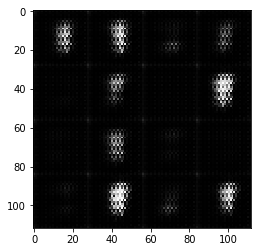

Epoch 1/5... Time Stamp 2017-07-30 18:10:36.876 Discriminator Loss: 0.4245... Generator Loss: 5.1718
Epoch 1/5... Time Stamp 2017-07-30 18:10:49.022 Discriminator Loss: 1.3352... Generator Loss: 6.8731
Epoch 1/5... Time Stamp 2017-07-30 18:11:01.173 Discriminator Loss: 0.4688... Generator Loss: 3.4397
Epoch 1/5... Time Stamp 2017-07-30 18:11:13.328 Discriminator Loss: 0.9882... Generator Loss: 1.2426
Epoch 1/5... Time Stamp 2017-07-30 18:11:25.446 Discriminator Loss: 0.5915... Generator Loss: 2.6114
Epoch 1/5... Time Stamp 2017-07-30 18:11:37.582 Discriminator Loss: 0.7595... Generator Loss: 1.5761
Epoch 1/5... Time Stamp 2017-07-30 18:11:49.731 Discriminator Loss: 0.5215... Generator Loss: 2.5464
Epoch 1/5... Time Stamp 2017-07-30 18:12:01.918 Discriminator Loss: 0.5042... Generator Loss: 3.5890
Epoch 1/5... Time Stamp 2017-07-30 18:12:14.146 Discriminator Loss: 1.0697... Generator Loss: 1.0812
Epoch 1/5... Time Stamp 2017-07-30 18:12:26.349 Discriminator Loss: 0.9582... Generator Los

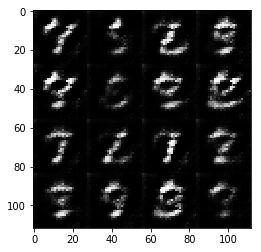

Epoch 1/5... Time Stamp 2017-07-30 18:12:39.015 Discriminator Loss: 1.7219... Generator Loss: 0.8317
Epoch 1/5... Time Stamp 2017-07-30 18:12:51.182 Discriminator Loss: 0.6862... Generator Loss: 1.9986
Epoch 1/5... Time Stamp 2017-07-30 18:13:03.357 Discriminator Loss: 2.3723... Generator Loss: 6.1933
Epoch 1/5... Time Stamp 2017-07-30 18:13:15.510 Discriminator Loss: 1.8548... Generator Loss: 0.4689
Epoch 1/5... Time Stamp 2017-07-30 18:13:27.680 Discriminator Loss: 0.6881... Generator Loss: 2.4584
Epoch 1/5... Time Stamp 2017-07-30 18:13:39.830 Discriminator Loss: 0.7632... Generator Loss: 1.7235
Epoch 1/5... Time Stamp 2017-07-30 18:13:51.978 Discriminator Loss: 1.0242... Generator Loss: 1.5419
Epoch 1/5... Time Stamp 2017-07-30 18:14:04.105 Discriminator Loss: 1.6184... Generator Loss: 0.5162
Epoch 1/5... Time Stamp 2017-07-30 18:14:16.246 Discriminator Loss: 0.7628... Generator Loss: 1.4317
Epoch 1/5... Time Stamp 2017-07-30 18:14:28.354 Discriminator Loss: 1.0054... Generator Los

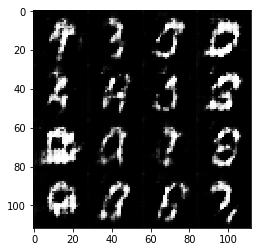

Epoch 1/5... Time Stamp 2017-07-30 18:14:41.112 Discriminator Loss: 0.7194... Generator Loss: 1.9156
Epoch 1/5... Time Stamp 2017-07-30 18:14:53.291 Discriminator Loss: 2.1762... Generator Loss: 0.2842
Epoch 1/5... Time Stamp 2017-07-30 18:15:05.448 Discriminator Loss: 1.0241... Generator Loss: 1.3284
Epoch 1/5... Time Stamp 2017-07-30 18:15:17.631 Discriminator Loss: 0.7179... Generator Loss: 2.0142
Epoch 1/5... Time Stamp 2017-07-30 18:15:29.725 Discriminator Loss: 0.9603... Generator Loss: 1.3736
Epoch 1/5... Time Stamp 2017-07-30 18:15:41.850 Discriminator Loss: 1.7129... Generator Loss: 0.4858
Epoch 1/5... Time Stamp 2017-07-30 18:15:54.001 Discriminator Loss: 1.4254... Generator Loss: 0.5928
Epoch 1/5... Time Stamp 2017-07-30 18:16:06.111 Discriminator Loss: 1.6685... Generator Loss: 0.4937
Epoch 1/5... Time Stamp 2017-07-30 18:16:18.242 Discriminator Loss: 1.4817... Generator Loss: 0.5599
Epoch 1/5... Time Stamp 2017-07-30 18:16:30.352 Discriminator Loss: 0.8154... Generator Los

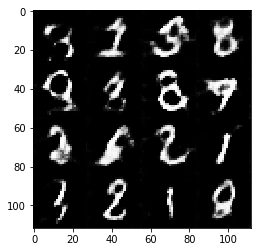

Epoch 1/5... Time Stamp 2017-07-30 18:16:43.081 Discriminator Loss: 1.0244... Generator Loss: 1.7378
Epoch 1/5... Time Stamp 2017-07-30 18:16:55.192 Discriminator Loss: 0.9858... Generator Loss: 1.6862
Epoch 1/5... Time Stamp 2017-07-30 18:17:07.313 Discriminator Loss: 1.1194... Generator Loss: 1.5840
Epoch 1/5... Time Stamp 2017-07-30 18:17:19.423 Discriminator Loss: 1.1576... Generator Loss: 0.8921
Epoch 1/5... Time Stamp 2017-07-30 18:17:31.530 Discriminator Loss: 0.7966... Generator Loss: 2.1360
Epoch 1/5... Time Stamp 2017-07-30 18:17:43.644 Discriminator Loss: 1.1239... Generator Loss: 1.0339
Epoch 1/5... Time Stamp 2017-07-30 18:17:55.749 Discriminator Loss: 1.1264... Generator Loss: 0.7181
Epoch 1/5... Time Stamp 2017-07-30 18:18:07.840 Discriminator Loss: 1.0611... Generator Loss: 1.2527
Epoch 1/5... Time Stamp 2017-07-30 18:18:19.989 Discriminator Loss: 1.0205... Generator Loss: 1.5771
Epoch 1/5... Time Stamp 2017-07-30 18:18:32.147 Discriminator Loss: 1.0327... Generator Los

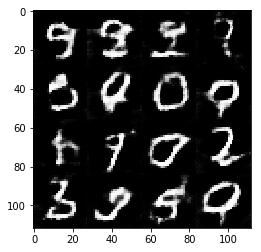

Epoch 1/5... Time Stamp 2017-07-30 18:18:44.669 Discriminator Loss: 1.6436... Generator Loss: 3.1415
Epoch 1/5... Time Stamp 2017-07-30 18:18:56.800 Discriminator Loss: 0.9487... Generator Loss: 1.3949
Epoch 1/5... Time Stamp 2017-07-30 18:19:08.953 Discriminator Loss: 1.3204... Generator Loss: 2.3495
Epoch 1/5... Time Stamp 2017-07-30 18:19:21.100 Discriminator Loss: 0.9637... Generator Loss: 1.2622
Epoch 1/5... Time Stamp 2017-07-30 18:19:33.397 Discriminator Loss: 0.9828... Generator Loss: 1.6881
Epoch 1/5... Time Stamp 2017-07-30 18:19:45.816 Discriminator Loss: 1.6327... Generator Loss: 0.4657
Epoch 1/5... Time Stamp 2017-07-30 18:19:58.334 Discriminator Loss: 1.2905... Generator Loss: 0.6773
Epoch 1/5... Time Stamp 2017-07-30 18:20:10.557 Discriminator Loss: 0.9796... Generator Loss: 1.0739
Epoch 1/5... Time Stamp 2017-07-30 18:20:22.684 Discriminator Loss: 1.0160... Generator Loss: 1.2248
Epoch 1/5... Time Stamp 2017-07-30 18:20:34.958 Discriminator Loss: 1.0903... Generator Los

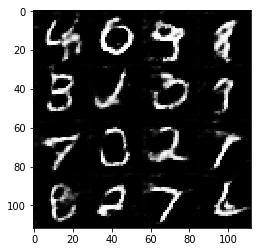

Epoch 1/5... Time Stamp 2017-07-30 18:20:47.642 Discriminator Loss: 1.1156... Generator Loss: 1.5212
Epoch 1/5... Time Stamp 2017-07-30 18:21:00.120 Discriminator Loss: 1.5107... Generator Loss: 2.3282
Epoch 1/5... Time Stamp 2017-07-30 18:21:12.647 Discriminator Loss: 1.2644... Generator Loss: 0.5983
Epoch 1/5... Time Stamp 2017-07-30 18:21:25.170 Discriminator Loss: 1.1614... Generator Loss: 0.7758
Epoch 1/5... Time Stamp 2017-07-30 18:21:37.593 Discriminator Loss: 1.0051... Generator Loss: 0.9504
Epoch 1/5... Time Stamp 2017-07-30 18:21:50.088 Discriminator Loss: 0.9801... Generator Loss: 1.4910
Epoch 1/5... Time Stamp 2017-07-30 18:22:02.663 Discriminator Loss: 1.1417... Generator Loss: 0.9825
Epoch 1/5... Time Stamp 2017-07-30 18:22:15.153 Discriminator Loss: 1.1854... Generator Loss: 0.8689
Epoch 1/5... Time Stamp 2017-07-30 18:22:27.336 Discriminator Loss: 1.0193... Generator Loss: 1.1259
Epoch 1/5... Time Stamp 2017-07-30 18:22:39.445 Discriminator Loss: 1.0451... Generator Los

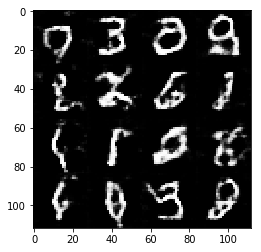

Epoch 1/5... Time Stamp 2017-07-30 18:22:51.967 Discriminator Loss: 1.7159... Generator Loss: 0.3780
Epoch 1/5... Time Stamp 2017-07-30 18:23:04.063 Discriminator Loss: 1.2331... Generator Loss: 0.6760
Epoch 1/5... Time Stamp 2017-07-30 18:23:16.316 Discriminator Loss: 1.4403... Generator Loss: 2.8518
Epoch 1/5... Time Stamp 2017-07-30 18:23:28.502 Discriminator Loss: 0.9393... Generator Loss: 1.1322
Epoch 1/5... Time Stamp 2017-07-30 18:23:40.592 Discriminator Loss: 1.0994... Generator Loss: 0.7778
Epoch 1/5... Time Stamp 2017-07-30 18:23:52.687 Discriminator Loss: 1.1822... Generator Loss: 0.7235
Epoch 1/5... Time Stamp 2017-07-30 18:24:04.801 Discriminator Loss: 0.9362... Generator Loss: 1.0675
Epoch 1/5... Time Stamp 2017-07-30 18:24:16.867 Discriminator Loss: 1.0285... Generator Loss: 1.1061
Epoch 1/5... Time Stamp 2017-07-30 18:24:29.012 Discriminator Loss: 1.2183... Generator Loss: 0.7403
Epoch 1/5... Time Stamp 2017-07-30 18:24:41.136 Discriminator Loss: 0.9234... Generator Los

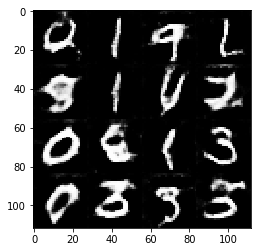

Epoch 1/5... Time Stamp 2017-07-30 18:24:53.811 Discriminator Loss: 0.9128... Generator Loss: 1.1330
Epoch 1/5... Time Stamp 2017-07-30 18:25:05.950 Discriminator Loss: 1.1291... Generator Loss: 0.8927
Epoch 1/5... Time Stamp 2017-07-30 18:25:18.042 Discriminator Loss: 1.6694... Generator Loss: 0.4129
Epoch 1/5... Time Stamp 2017-07-30 18:25:30.140 Discriminator Loss: 0.8056... Generator Loss: 1.5761
Epoch 1/5... Time Stamp 2017-07-30 18:25:42.261 Discriminator Loss: 0.8894... Generator Loss: 1.1889
Epoch 1/5... Time Stamp 2017-07-30 18:25:54.336 Discriminator Loss: 1.8184... Generator Loss: 0.4144
Epoch 1/5... Time Stamp 2017-07-30 18:26:06.432 Discriminator Loss: 1.1923... Generator Loss: 1.3673
Epoch 1/5... Time Stamp 2017-07-30 18:26:18.558 Discriminator Loss: 1.1653... Generator Loss: 0.7050
Epoch 1/5... Time Stamp 2017-07-30 18:26:30.672 Discriminator Loss: 1.1075... Generator Loss: 0.8344
Epoch 1/5... Time Stamp 2017-07-30 18:26:42.785 Discriminator Loss: 1.0547... Generator Los

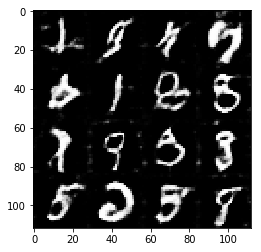

Epoch 1/5... Time Stamp 2017-07-30 18:26:55.391 Discriminator Loss: 1.0862... Generator Loss: 1.1888
Epoch 1/5... Time Stamp 2017-07-30 18:27:07.481 Discriminator Loss: 1.2019... Generator Loss: 2.2219
Epoch 1/5... Time Stamp 2017-07-30 18:27:19.607 Discriminator Loss: 1.1754... Generator Loss: 1.7100
Epoch 2/5... Time Stamp 2017-07-30 18:27:31.724 Discriminator Loss: 1.4897... Generator Loss: 0.4871
Epoch 2/5... Time Stamp 2017-07-30 18:27:43.784 Discriminator Loss: 1.0884... Generator Loss: 0.9123
Epoch 2/5... Time Stamp 2017-07-30 18:27:55.906 Discriminator Loss: 1.1788... Generator Loss: 0.7576
Epoch 2/5... Time Stamp 2017-07-30 18:28:08.009 Discriminator Loss: 1.4445... Generator Loss: 0.4880
Epoch 2/5... Time Stamp 2017-07-30 18:28:20.366 Discriminator Loss: 1.1178... Generator Loss: 1.8272
Epoch 2/5... Time Stamp 2017-07-30 18:28:32.805 Discriminator Loss: 1.5225... Generator Loss: 0.5156
Epoch 2/5... Time Stamp 2017-07-30 18:28:45.326 Discriminator Loss: 1.1808... Generator Los

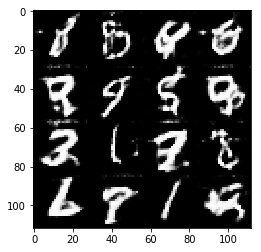

Epoch 2/5... Time Stamp 2017-07-30 18:28:58.631 Discriminator Loss: 0.9841... Generator Loss: 0.9913
Epoch 2/5... Time Stamp 2017-07-30 18:29:11.098 Discriminator Loss: 0.8762... Generator Loss: 1.1731
Epoch 2/5... Time Stamp 2017-07-30 18:29:23.408 Discriminator Loss: 0.8550... Generator Loss: 1.4375
Epoch 2/5... Time Stamp 2017-07-30 18:29:35.531 Discriminator Loss: 1.2029... Generator Loss: 1.1219
Epoch 2/5... Time Stamp 2017-07-30 18:29:47.607 Discriminator Loss: 1.5827... Generator Loss: 0.4386
Epoch 2/5... Time Stamp 2017-07-30 18:29:59.695 Discriminator Loss: 1.0846... Generator Loss: 0.9125
Epoch 2/5... Time Stamp 2017-07-30 18:30:11.815 Discriminator Loss: 1.5264... Generator Loss: 0.4636
Epoch 2/5... Time Stamp 2017-07-30 18:30:23.885 Discriminator Loss: 1.6062... Generator Loss: 0.4394
Epoch 2/5... Time Stamp 2017-07-30 18:30:35.992 Discriminator Loss: 1.0037... Generator Loss: 1.0414
Epoch 2/5... Time Stamp 2017-07-30 18:30:48.105 Discriminator Loss: 1.0474... Generator Los

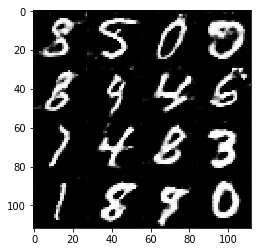

Epoch 2/5... Time Stamp 2017-07-30 18:31:00.652 Discriminator Loss: 0.9687... Generator Loss: 1.0101
Epoch 2/5... Time Stamp 2017-07-30 18:31:12.723 Discriminator Loss: 0.9967... Generator Loss: 1.9335
Epoch 2/5... Time Stamp 2017-07-30 18:31:24.865 Discriminator Loss: 1.4084... Generator Loss: 0.5331
Epoch 2/5... Time Stamp 2017-07-30 18:31:36.988 Discriminator Loss: 0.9753... Generator Loss: 1.5410
Epoch 2/5... Time Stamp 2017-07-30 18:31:49.051 Discriminator Loss: 1.1141... Generator Loss: 1.3232
Epoch 2/5... Time Stamp 2017-07-30 18:32:01.118 Discriminator Loss: 1.0338... Generator Loss: 1.2217
Epoch 2/5... Time Stamp 2017-07-30 18:32:13.182 Discriminator Loss: 1.4432... Generator Loss: 0.5362
Epoch 2/5... Time Stamp 2017-07-30 18:32:25.284 Discriminator Loss: 1.1960... Generator Loss: 0.7553
Epoch 2/5... Time Stamp 2017-07-30 18:32:37.374 Discriminator Loss: 1.1838... Generator Loss: 0.7780
Epoch 2/5... Time Stamp 2017-07-30 18:32:49.452 Discriminator Loss: 1.6296... Generator Los

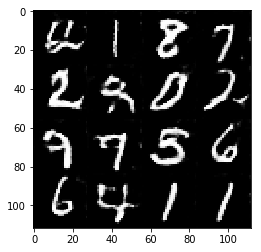

Epoch 2/5... Time Stamp 2017-07-30 18:33:01.940 Discriminator Loss: 0.9636... Generator Loss: 1.3955
Epoch 2/5... Time Stamp 2017-07-30 18:33:14.034 Discriminator Loss: 1.0294... Generator Loss: 0.9922
Epoch 2/5... Time Stamp 2017-07-30 18:33:26.122 Discriminator Loss: 1.4502... Generator Loss: 0.4968
Epoch 2/5... Time Stamp 2017-07-30 18:33:38.227 Discriminator Loss: 1.2716... Generator Loss: 0.6981
Epoch 2/5... Time Stamp 2017-07-30 18:33:50.335 Discriminator Loss: 1.0483... Generator Loss: 1.3747
Epoch 2/5... Time Stamp 2017-07-30 18:34:02.423 Discriminator Loss: 1.2631... Generator Loss: 2.3484
Epoch 2/5... Time Stamp 2017-07-30 18:34:14.512 Discriminator Loss: 1.7663... Generator Loss: 0.3787
Epoch 2/5... Time Stamp 2017-07-30 18:34:26.589 Discriminator Loss: 1.1899... Generator Loss: 0.8038
Epoch 2/5... Time Stamp 2017-07-30 18:34:38.659 Discriminator Loss: 1.0618... Generator Loss: 1.5586
Epoch 2/5... Time Stamp 2017-07-30 18:34:50.745 Discriminator Loss: 1.0097... Generator Los

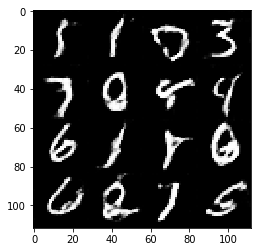

Epoch 2/5... Time Stamp 2017-07-30 18:35:03.299 Discriminator Loss: 1.1945... Generator Loss: 0.9205
Epoch 2/5... Time Stamp 2017-07-30 18:35:15.396 Discriminator Loss: 1.1818... Generator Loss: 0.9575
Epoch 2/5... Time Stamp 2017-07-30 18:35:27.500 Discriminator Loss: 1.4482... Generator Loss: 2.2631
Epoch 2/5... Time Stamp 2017-07-30 18:35:39.585 Discriminator Loss: 1.4062... Generator Loss: 2.4770
Epoch 2/5... Time Stamp 2017-07-30 18:35:51.655 Discriminator Loss: 1.1905... Generator Loss: 0.7564
Epoch 2/5... Time Stamp 2017-07-30 18:36:03.766 Discriminator Loss: 0.9821... Generator Loss: 1.0672
Epoch 2/5... Time Stamp 2017-07-30 18:36:15.831 Discriminator Loss: 1.2637... Generator Loss: 0.6667
Epoch 2/5... Time Stamp 2017-07-30 18:36:27.938 Discriminator Loss: 1.2242... Generator Loss: 0.6902
Epoch 2/5... Time Stamp 2017-07-30 18:36:40.015 Discriminator Loss: 1.6520... Generator Loss: 0.4522
Epoch 2/5... Time Stamp 2017-07-30 18:36:52.114 Discriminator Loss: 1.0254... Generator Los

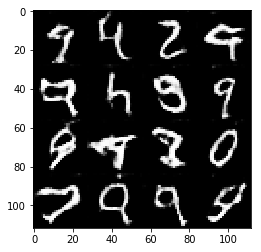

Epoch 2/5... Time Stamp 2017-07-30 18:37:04.658 Discriminator Loss: 1.0970... Generator Loss: 0.8726
Epoch 2/5... Time Stamp 2017-07-30 18:37:16.747 Discriminator Loss: 1.2758... Generator Loss: 2.4347
Epoch 2/5... Time Stamp 2017-07-30 18:37:28.814 Discriminator Loss: 1.1194... Generator Loss: 0.8162
Epoch 2/5... Time Stamp 2017-07-30 18:37:40.928 Discriminator Loss: 0.8956... Generator Loss: 1.7281
Epoch 2/5... Time Stamp 2017-07-30 18:37:52.983 Discriminator Loss: 0.9396... Generator Loss: 1.2947
Epoch 2/5... Time Stamp 2017-07-30 18:38:05.067 Discriminator Loss: 1.0231... Generator Loss: 0.9061
Epoch 2/5... Time Stamp 2017-07-30 18:38:17.211 Discriminator Loss: 0.9849... Generator Loss: 0.9849
Epoch 2/5... Time Stamp 2017-07-30 18:38:29.394 Discriminator Loss: 1.4792... Generator Loss: 2.7643
Epoch 2/5... Time Stamp 2017-07-30 18:38:41.760 Discriminator Loss: 1.1263... Generator Loss: 0.7679
Epoch 2/5... Time Stamp 2017-07-30 18:38:54.190 Discriminator Loss: 1.5248... Generator Los

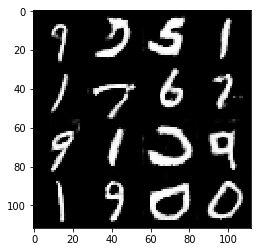

Epoch 2/5... Time Stamp 2017-07-30 18:39:06.924 Discriminator Loss: 1.0419... Generator Loss: 0.8822
Epoch 2/5... Time Stamp 2017-07-30 18:39:18.974 Discriminator Loss: 1.4029... Generator Loss: 0.5523
Epoch 2/5... Time Stamp 2017-07-30 18:39:31.151 Discriminator Loss: 0.8698... Generator Loss: 2.1485
Epoch 2/5... Time Stamp 2017-07-30 18:39:43.555 Discriminator Loss: 1.0046... Generator Loss: 2.2498
Epoch 2/5... Time Stamp 2017-07-30 18:39:56.008 Discriminator Loss: 1.4616... Generator Loss: 0.5157
Epoch 2/5... Time Stamp 2017-07-30 18:40:08.449 Discriminator Loss: 1.0590... Generator Loss: 2.0189
Epoch 2/5... Time Stamp 2017-07-30 18:40:20.812 Discriminator Loss: 1.1511... Generator Loss: 1.1049
Epoch 2/5... Time Stamp 2017-07-30 18:40:33.340 Discriminator Loss: 0.9105... Generator Loss: 1.1395
Epoch 2/5... Time Stamp 2017-07-30 18:40:45.518 Discriminator Loss: 1.0421... Generator Loss: 1.2714
Epoch 2/5... Time Stamp 2017-07-30 18:40:57.573 Discriminator Loss: 1.0571... Generator Los

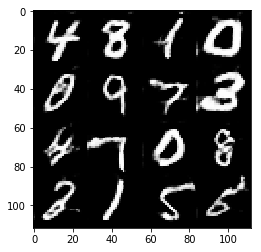

Epoch 2/5... Time Stamp 2017-07-30 18:41:10.072 Discriminator Loss: 1.3036... Generator Loss: 0.6290
Epoch 2/5... Time Stamp 2017-07-30 18:41:22.151 Discriminator Loss: 0.8977... Generator Loss: 1.3393
Epoch 2/5... Time Stamp 2017-07-30 18:41:34.220 Discriminator Loss: 1.0366... Generator Loss: 0.8792
Epoch 2/5... Time Stamp 2017-07-30 18:41:46.336 Discriminator Loss: 1.2412... Generator Loss: 0.7206
Epoch 2/5... Time Stamp 2017-07-30 18:41:58.387 Discriminator Loss: 0.9648... Generator Loss: 0.9964
Epoch 2/5... Time Stamp 2017-07-30 18:42:10.474 Discriminator Loss: 0.9372... Generator Loss: 1.8258
Epoch 2/5... Time Stamp 2017-07-30 18:42:22.526 Discriminator Loss: 1.1977... Generator Loss: 0.7321
Epoch 2/5... Time Stamp 2017-07-30 18:42:34.612 Discriminator Loss: 0.9315... Generator Loss: 1.9164
Epoch 2/5... Time Stamp 2017-07-30 18:42:46.681 Discriminator Loss: 1.0747... Generator Loss: 0.8654
Epoch 2/5... Time Stamp 2017-07-30 18:42:58.758 Discriminator Loss: 1.4391... Generator Los

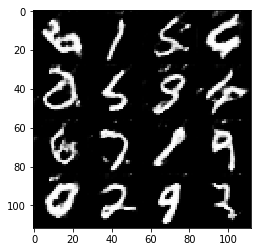

Epoch 2/5... Time Stamp 2017-07-30 18:43:11.433 Discriminator Loss: 1.0613... Generator Loss: 0.9884
Epoch 2/5... Time Stamp 2017-07-30 18:43:23.481 Discriminator Loss: 1.3349... Generator Loss: 0.6164
Epoch 2/5... Time Stamp 2017-07-30 18:43:35.601 Discriminator Loss: 1.1437... Generator Loss: 0.9215
Epoch 2/5... Time Stamp 2017-07-30 18:43:47.743 Discriminator Loss: 1.5256... Generator Loss: 2.4840
Epoch 2/5... Time Stamp 2017-07-30 18:44:00.170 Discriminator Loss: 0.9781... Generator Loss: 1.2971
Epoch 2/5... Time Stamp 2017-07-30 18:44:12.660 Discriminator Loss: 0.8391... Generator Loss: 1.3460
Epoch 2/5... Time Stamp 2017-07-30 18:44:25.126 Discriminator Loss: 1.5288... Generator Loss: 0.4836
Epoch 2/5... Time Stamp 2017-07-30 18:44:37.595 Discriminator Loss: 1.5744... Generator Loss: 0.4931
Epoch 2/5... Time Stamp 2017-07-30 18:44:50.006 Discriminator Loss: 0.8314... Generator Loss: 1.1594
Epoch 2/5... Time Stamp 2017-07-30 18:45:02.440 Discriminator Loss: 0.7986... Generator Los

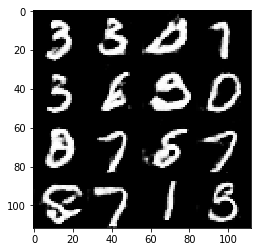

Epoch 2/5... Time Stamp 2017-07-30 18:45:15.566 Discriminator Loss: 0.8895... Generator Loss: 1.4532
Epoch 2/5... Time Stamp 2017-07-30 18:45:27.626 Discriminator Loss: 1.3000... Generator Loss: 0.5998
Epoch 2/5... Time Stamp 2017-07-30 18:45:39.694 Discriminator Loss: 0.8797... Generator Loss: 1.2511
Epoch 2/5... Time Stamp 2017-07-30 18:45:51.773 Discriminator Loss: 1.3682... Generator Loss: 0.6330
Epoch 2/5... Time Stamp 2017-07-30 18:46:03.853 Discriminator Loss: 1.1040... Generator Loss: 0.7878
Epoch 2/5... Time Stamp 2017-07-30 18:46:15.917 Discriminator Loss: 2.2116... Generator Loss: 3.3743
Epoch 2/5... Time Stamp 2017-07-30 18:46:27.982 Discriminator Loss: 1.3867... Generator Loss: 0.5993
Epoch 3/5... Time Stamp 2017-07-30 18:46:40.055 Discriminator Loss: 1.6332... Generator Loss: 2.7355
Epoch 3/5... Time Stamp 2017-07-30 18:46:52.140 Discriminator Loss: 1.3810... Generator Loss: 0.6113
Epoch 3/5... Time Stamp 2017-07-30 18:47:04.527 Discriminator Loss: 1.1612... Generator Los

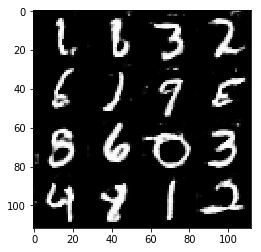

Epoch 3/5... Time Stamp 2017-07-30 18:47:17.710 Discriminator Loss: 0.9939... Generator Loss: 1.9554
Epoch 3/5... Time Stamp 2017-07-30 18:47:29.894 Discriminator Loss: 1.0857... Generator Loss: 0.8396
Epoch 3/5... Time Stamp 2017-07-30 18:47:42.346 Discriminator Loss: 0.9651... Generator Loss: 1.3323
Epoch 3/5... Time Stamp 2017-07-30 18:47:54.782 Discriminator Loss: 1.2863... Generator Loss: 0.6912
Epoch 3/5... Time Stamp 2017-07-30 18:48:07.190 Discriminator Loss: 1.2182... Generator Loss: 1.1364
Epoch 3/5... Time Stamp 2017-07-30 18:48:19.613 Discriminator Loss: 0.9368... Generator Loss: 1.2562
Epoch 3/5... Time Stamp 2017-07-30 18:48:32.108 Discriminator Loss: 0.9897... Generator Loss: 1.2027
Epoch 3/5... Time Stamp 2017-07-30 18:48:44.560 Discriminator Loss: 1.1646... Generator Loss: 1.3535
Epoch 3/5... Time Stamp 2017-07-30 18:48:57.027 Discriminator Loss: 1.5569... Generator Loss: 0.5103
Epoch 3/5... Time Stamp 2017-07-30 18:49:09.440 Discriminator Loss: 1.1027... Generator Los

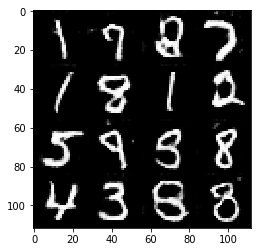

Epoch 3/5... Time Stamp 2017-07-30 18:49:22.207 Discriminator Loss: 1.3626... Generator Loss: 0.5814
Epoch 3/5... Time Stamp 2017-07-30 18:49:34.335 Discriminator Loss: 0.8575... Generator Loss: 1.5850
Epoch 3/5... Time Stamp 2017-07-30 18:49:46.445 Discriminator Loss: 1.2078... Generator Loss: 0.7711
Epoch 3/5... Time Stamp 2017-07-30 18:49:58.641 Discriminator Loss: 0.9864... Generator Loss: 1.4863
Epoch 3/5... Time Stamp 2017-07-30 18:50:10.724 Discriminator Loss: 0.7854... Generator Loss: 2.0582
Epoch 3/5... Time Stamp 2017-07-30 18:50:22.764 Discriminator Loss: 1.3132... Generator Loss: 3.3009
Epoch 3/5... Time Stamp 2017-07-30 18:50:34.898 Discriminator Loss: 0.9296... Generator Loss: 1.1524
Epoch 3/5... Time Stamp 2017-07-30 18:50:46.952 Discriminator Loss: 0.9779... Generator Loss: 1.5866
Epoch 3/5... Time Stamp 2017-07-30 18:50:59.041 Discriminator Loss: 1.9983... Generator Loss: 0.2924
Epoch 3/5... Time Stamp 2017-07-30 18:51:11.151 Discriminator Loss: 1.0110... Generator Los

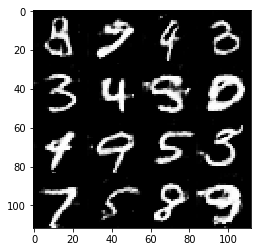

Epoch 3/5... Time Stamp 2017-07-30 18:51:23.768 Discriminator Loss: 1.3916... Generator Loss: 0.5663
Epoch 3/5... Time Stamp 2017-07-30 18:51:35.841 Discriminator Loss: 3.5111... Generator Loss: 4.6815
Epoch 3/5... Time Stamp 2017-07-30 18:51:47.913 Discriminator Loss: 1.0064... Generator Loss: 0.9839
Epoch 3/5... Time Stamp 2017-07-30 18:52:00.006 Discriminator Loss: 1.5216... Generator Loss: 0.4671
Epoch 3/5... Time Stamp 2017-07-30 18:52:12.081 Discriminator Loss: 1.4844... Generator Loss: 0.6656
Epoch 3/5... Time Stamp 2017-07-30 18:52:24.166 Discriminator Loss: 0.8635... Generator Loss: 1.4881
Epoch 3/5... Time Stamp 2017-07-30 18:52:36.244 Discriminator Loss: 1.1060... Generator Loss: 0.8313
Epoch 3/5... Time Stamp 2017-07-30 18:52:48.328 Discriminator Loss: 0.9220... Generator Loss: 1.4601
Epoch 3/5... Time Stamp 2017-07-30 18:53:00.396 Discriminator Loss: 0.9935... Generator Loss: 1.1798
Epoch 3/5... Time Stamp 2017-07-30 18:53:12.480 Discriminator Loss: 1.0306... Generator Los

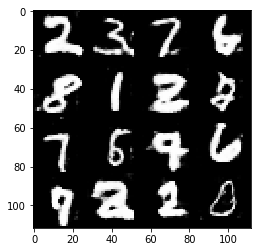

Epoch 3/5... Time Stamp 2017-07-30 18:53:24.999 Discriminator Loss: 1.5770... Generator Loss: 3.0484
Epoch 3/5... Time Stamp 2017-07-30 18:53:37.084 Discriminator Loss: 1.1519... Generator Loss: 0.7450
Epoch 3/5... Time Stamp 2017-07-30 18:53:49.306 Discriminator Loss: 0.9443... Generator Loss: 1.2313
Epoch 3/5... Time Stamp 2017-07-30 18:54:01.763 Discriminator Loss: 0.7319... Generator Loss: 1.9279
Epoch 3/5... Time Stamp 2017-07-30 18:54:14.227 Discriminator Loss: 0.7053... Generator Loss: 1.6236
Epoch 3/5... Time Stamp 2017-07-30 18:54:26.652 Discriminator Loss: 1.2106... Generator Loss: 0.8456
Epoch 3/5... Time Stamp 2017-07-30 18:54:39.120 Discriminator Loss: 0.8634... Generator Loss: 1.8650
Epoch 3/5... Time Stamp 2017-07-30 18:54:51.605 Discriminator Loss: 0.9934... Generator Loss: 0.9392
Epoch 3/5... Time Stamp 2017-07-30 18:55:04.039 Discriminator Loss: 1.1117... Generator Loss: 0.7751
Epoch 3/5... Time Stamp 2017-07-30 18:55:16.488 Discriminator Loss: 1.1312... Generator Los

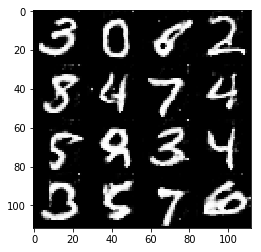

Epoch 3/5... Time Stamp 2017-07-30 18:55:29.410 Discriminator Loss: 0.6799... Generator Loss: 1.5758
Epoch 3/5... Time Stamp 2017-07-30 18:55:41.491 Discriminator Loss: 0.6467... Generator Loss: 1.6342
Epoch 3/5... Time Stamp 2017-07-30 18:55:53.571 Discriminator Loss: 0.9055... Generator Loss: 1.3928
Epoch 3/5... Time Stamp 2017-07-30 18:56:05.664 Discriminator Loss: 1.4792... Generator Loss: 2.5176
Epoch 3/5... Time Stamp 2017-07-30 18:56:17.755 Discriminator Loss: 1.2633... Generator Loss: 0.6128
Epoch 3/5... Time Stamp 2017-07-30 18:56:29.842 Discriminator Loss: 0.9142... Generator Loss: 1.1866
Epoch 3/5... Time Stamp 2017-07-30 18:56:41.939 Discriminator Loss: 1.5033... Generator Loss: 0.5285
Epoch 3/5... Time Stamp 2017-07-30 18:56:54.058 Discriminator Loss: 1.5010... Generator Loss: 0.5368
Epoch 3/5... Time Stamp 2017-07-30 18:57:06.136 Discriminator Loss: 0.9240... Generator Loss: 1.0582
Epoch 3/5... Time Stamp 2017-07-30 18:57:18.238 Discriminator Loss: 1.5073... Generator Los

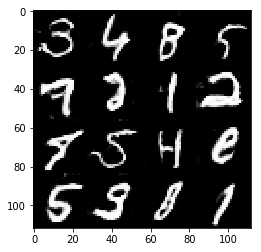

Epoch 3/5... Time Stamp 2017-07-30 18:57:30.800 Discriminator Loss: 1.0826... Generator Loss: 0.8744
Epoch 3/5... Time Stamp 2017-07-30 18:57:42.874 Discriminator Loss: 0.7157... Generator Loss: 1.6233
Epoch 3/5... Time Stamp 2017-07-30 18:57:54.965 Discriminator Loss: 2.0359... Generator Loss: 0.2632
Epoch 3/5... Time Stamp 2017-07-30 18:58:07.106 Discriminator Loss: 1.2529... Generator Loss: 0.8186
Epoch 3/5... Time Stamp 2017-07-30 18:58:19.505 Discriminator Loss: 1.1005... Generator Loss: 0.8667
Epoch 3/5... Time Stamp 2017-07-30 18:58:31.901 Discriminator Loss: 0.8330... Generator Loss: 1.2364
Epoch 3/5... Time Stamp 2017-07-30 18:58:44.356 Discriminator Loss: 0.7833... Generator Loss: 1.5422
Epoch 3/5... Time Stamp 2017-07-30 18:58:56.520 Discriminator Loss: 0.9914... Generator Loss: 0.9712
Epoch 3/5... Time Stamp 2017-07-30 18:59:08.644 Discriminator Loss: 0.7616... Generator Loss: 1.8702
Epoch 3/5... Time Stamp 2017-07-30 18:59:20.732 Discriminator Loss: 1.7681... Generator Los

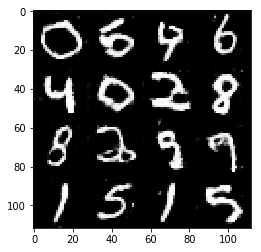

Epoch 3/5... Time Stamp 2017-07-30 18:59:33.257 Discriminator Loss: 0.8898... Generator Loss: 1.5752
Epoch 3/5... Time Stamp 2017-07-30 18:59:45.327 Discriminator Loss: 0.9574... Generator Loss: 1.0103
Epoch 3/5... Time Stamp 2017-07-30 18:59:57.558 Discriminator Loss: 0.7292... Generator Loss: 1.6577
Epoch 3/5... Time Stamp 2017-07-30 19:00:09.978 Discriminator Loss: 1.5560... Generator Loss: 0.4670
Epoch 3/5... Time Stamp 2017-07-30 19:00:22.418 Discriminator Loss: 1.0194... Generator Loss: 1.1826
Epoch 3/5... Time Stamp 2017-07-30 19:00:34.866 Discriminator Loss: 1.0254... Generator Loss: 0.8669
Epoch 3/5... Time Stamp 2017-07-30 19:00:47.244 Discriminator Loss: 1.3693... Generator Loss: 0.7513
Epoch 3/5... Time Stamp 2017-07-30 19:00:59.690 Discriminator Loss: 1.5789... Generator Loss: 0.4869
Epoch 3/5... Time Stamp 2017-07-30 19:01:12.129 Discriminator Loss: 2.1559... Generator Loss: 2.9744
Epoch 3/5... Time Stamp 2017-07-30 19:01:24.569 Discriminator Loss: 0.8104... Generator Los

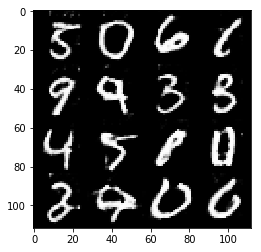

Epoch 3/5... Time Stamp 2017-07-30 19:01:37.780 Discriminator Loss: 0.6632... Generator Loss: 2.4434
Epoch 3/5... Time Stamp 2017-07-30 19:01:49.949 Discriminator Loss: 1.0681... Generator Loss: 0.9605
Epoch 3/5... Time Stamp 2017-07-30 19:02:02.399 Discriminator Loss: 0.7240... Generator Loss: 1.4026
Epoch 3/5... Time Stamp 2017-07-30 19:02:14.585 Discriminator Loss: 1.0632... Generator Loss: 0.8074
Epoch 3/5... Time Stamp 2017-07-30 19:02:26.683 Discriminator Loss: 0.9452... Generator Loss: 1.0519
Epoch 3/5... Time Stamp 2017-07-30 19:02:38.777 Discriminator Loss: 0.7418... Generator Loss: 1.4390
Epoch 3/5... Time Stamp 2017-07-30 19:02:50.880 Discriminator Loss: 0.6233... Generator Loss: 1.7966
Epoch 3/5... Time Stamp 2017-07-30 19:03:02.966 Discriminator Loss: 0.6927... Generator Loss: 1.6592
Epoch 3/5... Time Stamp 2017-07-30 19:03:15.068 Discriminator Loss: 0.9514... Generator Loss: 2.4321
Epoch 3/5... Time Stamp 2017-07-30 19:03:27.165 Discriminator Loss: 0.6716... Generator Los

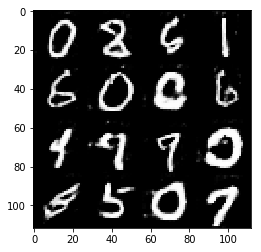

Epoch 3/5... Time Stamp 2017-07-30 19:03:40.505 Discriminator Loss: 1.1088... Generator Loss: 0.8911
Epoch 3/5... Time Stamp 2017-07-30 19:04:06.215 Discriminator Loss: 0.8711... Generator Loss: 1.2135
Epoch 3/5... Time Stamp 2017-07-30 19:04:24.179 Discriminator Loss: 0.9804... Generator Loss: 1.0803
Epoch 3/5... Time Stamp 2017-07-30 19:04:36.276 Discriminator Loss: 1.0883... Generator Loss: 1.6935
Epoch 3/5... Time Stamp 2017-07-30 19:04:48.491 Discriminator Loss: 1.1439... Generator Loss: 0.8390
Epoch 3/5... Time Stamp 2017-07-30 19:05:00.912 Discriminator Loss: 0.9227... Generator Loss: 1.4989
Epoch 3/5... Time Stamp 2017-07-30 19:05:13.401 Discriminator Loss: 0.8540... Generator Loss: 1.1972
Epoch 3/5... Time Stamp 2017-07-30 19:05:25.578 Discriminator Loss: 0.9407... Generator Loss: 1.0440
Epoch 3/5... Time Stamp 2017-07-30 19:05:37.661 Discriminator Loss: 0.8773... Generator Loss: 1.3177
Epoch 3/5... Time Stamp 2017-07-30 19:05:49.754 Discriminator Loss: 0.7782... Generator Los

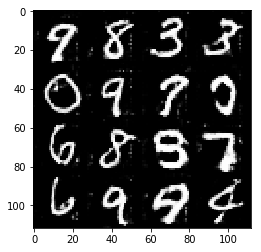

Epoch 3/5... Time Stamp 2017-07-30 19:06:02.309 Discriminator Loss: 0.6613... Generator Loss: 1.7687
Epoch 4/5... Time Stamp 2017-07-30 19:06:14.480 Discriminator Loss: 0.9425... Generator Loss: 2.8011
Epoch 4/5... Time Stamp 2017-07-30 19:06:26.600 Discriminator Loss: 1.1821... Generator Loss: 0.7099
Epoch 4/5... Time Stamp 2017-07-30 19:06:38.706 Discriminator Loss: 0.7592... Generator Loss: 1.6071
Epoch 4/5... Time Stamp 2017-07-30 19:06:50.814 Discriminator Loss: 0.5889... Generator Loss: 2.0222
Epoch 4/5... Time Stamp 2017-07-30 19:07:02.897 Discriminator Loss: 1.0222... Generator Loss: 1.3732
Epoch 4/5... Time Stamp 2017-07-30 19:07:14.985 Discriminator Loss: 0.9801... Generator Loss: 0.9009
Epoch 4/5... Time Stamp 2017-07-30 19:07:27.096 Discriminator Loss: 0.8561... Generator Loss: 1.3563
Epoch 4/5... Time Stamp 2017-07-30 19:07:39.401 Discriminator Loss: 1.1571... Generator Loss: 0.7808
Epoch 4/5... Time Stamp 2017-07-30 19:07:51.853 Discriminator Loss: 0.9415... Generator Los

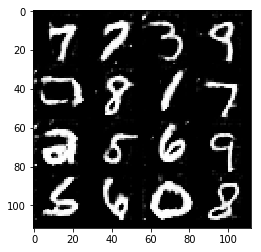

Epoch 4/5... Time Stamp 2017-07-30 19:08:05.127 Discriminator Loss: 0.9239... Generator Loss: 2.3308
Epoch 4/5... Time Stamp 2017-07-30 19:08:17.591 Discriminator Loss: 0.8020... Generator Loss: 1.9933
Epoch 4/5... Time Stamp 2017-07-30 19:08:30.155 Discriminator Loss: 0.9090... Generator Loss: 1.0956
Epoch 4/5... Time Stamp 2017-07-30 19:08:42.305 Discriminator Loss: 0.7506... Generator Loss: 1.5971
Epoch 4/5... Time Stamp 2017-07-30 19:08:54.390 Discriminator Loss: 1.1746... Generator Loss: 0.7470
Epoch 4/5... Time Stamp 2017-07-30 19:09:06.486 Discriminator Loss: 1.0672... Generator Loss: 0.9468
Epoch 4/5... Time Stamp 2017-07-30 19:09:18.561 Discriminator Loss: 0.7304... Generator Loss: 1.3712
Epoch 4/5... Time Stamp 2017-07-30 19:09:30.693 Discriminator Loss: 0.7807... Generator Loss: 2.7268
Epoch 4/5... Time Stamp 2017-07-30 19:09:42.798 Discriminator Loss: 1.0528... Generator Loss: 0.8952
Epoch 4/5... Time Stamp 2017-07-30 19:09:54.901 Discriminator Loss: 1.1806... Generator Los

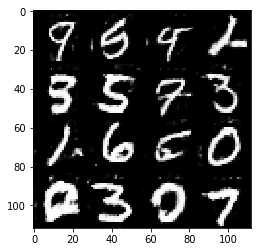

Epoch 4/5... Time Stamp 2017-07-30 19:10:07.651 Discriminator Loss: 1.0823... Generator Loss: 0.8335
Epoch 4/5... Time Stamp 2017-07-30 19:10:19.776 Discriminator Loss: 0.8942... Generator Loss: 2.4043
Epoch 4/5... Time Stamp 2017-07-30 19:10:31.916 Discriminator Loss: 1.4849... Generator Loss: 0.5807
Epoch 4/5... Time Stamp 2017-07-30 19:10:44.062 Discriminator Loss: 0.8940... Generator Loss: 2.1418
Epoch 4/5... Time Stamp 2017-07-30 19:10:56.205 Discriminator Loss: 1.3877... Generator Loss: 0.7165
Epoch 4/5... Time Stamp 2017-07-30 19:11:08.302 Discriminator Loss: 1.3100... Generator Loss: 0.6582
Epoch 4/5... Time Stamp 2017-07-30 19:11:20.401 Discriminator Loss: 0.7804... Generator Loss: 1.4335
Epoch 4/5... Time Stamp 2017-07-30 19:11:32.475 Discriminator Loss: 0.7523... Generator Loss: 2.2283
Epoch 4/5... Time Stamp 2017-07-30 19:11:44.580 Discriminator Loss: 2.1459... Generator Loss: 0.3147
Epoch 4/5... Time Stamp 2017-07-30 19:11:56.675 Discriminator Loss: 0.7017... Generator Los

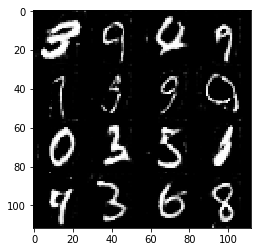

Epoch 4/5... Time Stamp 2017-07-30 19:12:09.229 Discriminator Loss: 0.9917... Generator Loss: 0.9858
Epoch 4/5... Time Stamp 2017-07-30 19:12:21.376 Discriminator Loss: 0.8472... Generator Loss: 1.7280
Epoch 4/5... Time Stamp 2017-07-30 19:12:33.495 Discriminator Loss: 0.9836... Generator Loss: 1.1581
Epoch 4/5... Time Stamp 2017-07-30 19:12:45.594 Discriminator Loss: 0.8810... Generator Loss: 1.0788
Epoch 4/5... Time Stamp 2017-07-30 19:12:57.777 Discriminator Loss: 1.3420... Generator Loss: 0.5969
Epoch 4/5... Time Stamp 2017-07-30 19:13:09.890 Discriminator Loss: 0.6150... Generator Loss: 1.6711
Epoch 4/5... Time Stamp 2017-07-30 19:13:22.006 Discriminator Loss: 0.7552... Generator Loss: 1.3409
Epoch 4/5... Time Stamp 2017-07-30 19:13:34.079 Discriminator Loss: 0.6133... Generator Loss: 1.7236
Epoch 4/5... Time Stamp 2017-07-30 19:13:46.209 Discriminator Loss: 0.6550... Generator Loss: 2.2943
Epoch 4/5... Time Stamp 2017-07-30 19:13:58.293 Discriminator Loss: 0.8143... Generator Los

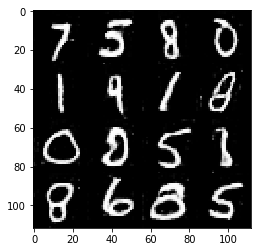

Epoch 4/5... Time Stamp 2017-07-30 19:14:11.001 Discriminator Loss: 0.8827... Generator Loss: 1.8124
Epoch 4/5... Time Stamp 2017-07-30 19:14:23.093 Discriminator Loss: 0.8773... Generator Loss: 1.1466
Epoch 4/5... Time Stamp 2017-07-30 19:14:35.228 Discriminator Loss: 0.6907... Generator Loss: 1.5415
Epoch 4/5... Time Stamp 2017-07-30 19:14:47.308 Discriminator Loss: 0.8747... Generator Loss: 1.0644
Epoch 4/5... Time Stamp 2017-07-30 19:14:59.505 Discriminator Loss: 0.7957... Generator Loss: 1.3310
Epoch 4/5... Time Stamp 2017-07-30 19:15:11.978 Discriminator Loss: 4.3086... Generator Loss: 0.0705
Epoch 4/5... Time Stamp 2017-07-30 19:15:24.480 Discriminator Loss: 0.8367... Generator Loss: 2.5071
Epoch 4/5... Time Stamp 2017-07-30 19:15:36.595 Discriminator Loss: 1.0336... Generator Loss: 1.0223
Epoch 4/5... Time Stamp 2017-07-30 19:15:48.668 Discriminator Loss: 1.0529... Generator Loss: 0.9181
Epoch 4/5... Time Stamp 2017-07-30 19:16:00.764 Discriminator Loss: 2.4048... Generator Los

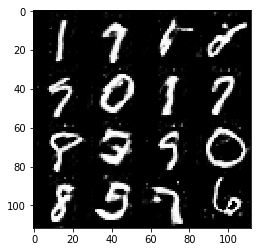

Epoch 4/5... Time Stamp 2017-07-30 19:16:13.835 Discriminator Loss: 0.8609... Generator Loss: 1.3301
Epoch 4/5... Time Stamp 2017-07-30 19:16:26.227 Discriminator Loss: 1.2278... Generator Loss: 0.7571
Epoch 4/5... Time Stamp 2017-07-30 19:16:38.647 Discriminator Loss: 0.6329... Generator Loss: 1.7928
Epoch 4/5... Time Stamp 2017-07-30 19:16:51.103 Discriminator Loss: 1.0145... Generator Loss: 0.9144
Epoch 4/5... Time Stamp 2017-07-30 19:17:03.589 Discriminator Loss: 1.3561... Generator Loss: 0.7249
Epoch 4/5... Time Stamp 2017-07-30 19:17:16.089 Discriminator Loss: 0.7961... Generator Loss: 1.9924
Epoch 4/5... Time Stamp 2017-07-30 19:17:28.563 Discriminator Loss: 0.6428... Generator Loss: 1.9496
Epoch 4/5... Time Stamp 2017-07-30 19:17:41.065 Discriminator Loss: 1.4703... Generator Loss: 3.6523
Epoch 4/5... Time Stamp 2017-07-30 19:17:53.513 Discriminator Loss: 0.7955... Generator Loss: 2.6348
Epoch 4/5... Time Stamp 2017-07-30 19:18:05.931 Discriminator Loss: 0.8304... Generator Los

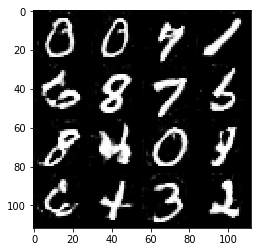

Epoch 4/5... Time Stamp 2017-07-30 19:18:19.019 Discriminator Loss: 0.6601... Generator Loss: 1.7988
Epoch 4/5... Time Stamp 2017-07-30 19:18:31.098 Discriminator Loss: 0.7152... Generator Loss: 2.2911
Epoch 4/5... Time Stamp 2017-07-30 19:18:43.300 Discriminator Loss: 0.8888... Generator Loss: 1.2057
Epoch 4/5... Time Stamp 2017-07-30 19:18:55.741 Discriminator Loss: 1.2193... Generator Loss: 0.7708
Epoch 4/5... Time Stamp 2017-07-30 19:19:08.249 Discriminator Loss: 1.0101... Generator Loss: 0.9367
Epoch 4/5... Time Stamp 2017-07-30 19:19:20.681 Discriminator Loss: 0.7092... Generator Loss: 1.5107
Epoch 4/5... Time Stamp 2017-07-30 19:19:33.309 Discriminator Loss: 1.2118... Generator Loss: 0.8029
Epoch 4/5... Time Stamp 2017-07-30 19:19:45.787 Discriminator Loss: 0.8379... Generator Loss: 1.1468
Epoch 4/5... Time Stamp 2017-07-30 19:19:58.233 Discriminator Loss: 1.2106... Generator Loss: 0.6770
Epoch 4/5... Time Stamp 2017-07-30 19:20:10.719 Discriminator Loss: 0.7517... Generator Los

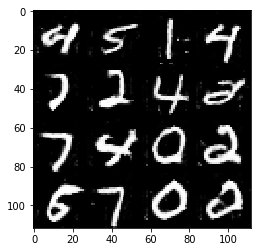

Epoch 4/5... Time Stamp 2017-07-30 19:20:23.920 Discriminator Loss: 1.1140... Generator Loss: 0.7683
Epoch 4/5... Time Stamp 2017-07-30 19:20:36.039 Discriminator Loss: 2.0270... Generator Loss: 0.3914
Epoch 4/5... Time Stamp 2017-07-30 19:20:48.167 Discriminator Loss: 0.9748... Generator Loss: 1.0243
Epoch 4/5... Time Stamp 2017-07-30 19:21:00.319 Discriminator Loss: 1.4126... Generator Loss: 0.6028
Epoch 4/5... Time Stamp 2017-07-30 19:21:12.428 Discriminator Loss: 0.8991... Generator Loss: 1.1528
Epoch 4/5... Time Stamp 2017-07-30 19:21:24.653 Discriminator Loss: 0.6019... Generator Loss: 2.1104
Epoch 4/5... Time Stamp 2017-07-30 19:21:36.838 Discriminator Loss: 0.7973... Generator Loss: 1.2038
Epoch 4/5... Time Stamp 2017-07-30 19:21:48.993 Discriminator Loss: 0.8931... Generator Loss: 1.9917
Epoch 4/5... Time Stamp 2017-07-30 19:22:01.115 Discriminator Loss: 3.6566... Generator Loss: 0.1225
Epoch 4/5... Time Stamp 2017-07-30 19:22:13.213 Discriminator Loss: 1.3243... Generator Los

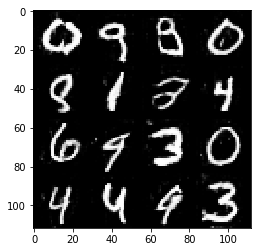

Epoch 4/5... Time Stamp 2017-07-30 19:22:25.760 Discriminator Loss: 0.7941... Generator Loss: 1.4964
Epoch 4/5... Time Stamp 2017-07-30 19:22:37.845 Discriminator Loss: 1.2219... Generator Loss: 0.7437
Epoch 4/5... Time Stamp 2017-07-30 19:22:49.921 Discriminator Loss: 0.9434... Generator Loss: 1.1887
Epoch 4/5... Time Stamp 2017-07-30 19:23:02.023 Discriminator Loss: 0.9235... Generator Loss: 1.0771
Epoch 4/5... Time Stamp 2017-07-30 19:23:14.123 Discriminator Loss: 0.7911... Generator Loss: 1.2872
Epoch 4/5... Time Stamp 2017-07-30 19:23:26.245 Discriminator Loss: 0.7776... Generator Loss: 2.0807
Epoch 4/5... Time Stamp 2017-07-30 19:23:38.363 Discriminator Loss: 0.9392... Generator Loss: 3.8100
Epoch 4/5... Time Stamp 2017-07-30 19:23:50.499 Discriminator Loss: 2.1491... Generator Loss: 0.3120
Epoch 4/5... Time Stamp 2017-07-30 19:24:02.701 Discriminator Loss: 0.7406... Generator Loss: 1.4877
Epoch 4/5... Time Stamp 2017-07-30 19:24:14.789 Discriminator Loss: 0.9342... Generator Los

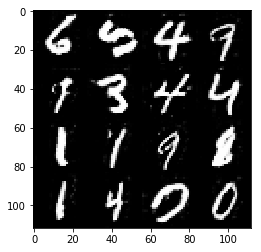

Epoch 4/5... Time Stamp 2017-07-30 19:24:27.489 Discriminator Loss: 0.7621... Generator Loss: 1.3671
Epoch 4/5... Time Stamp 2017-07-30 19:24:39.630 Discriminator Loss: 0.7622... Generator Loss: 1.3172
Epoch 4/5... Time Stamp 2017-07-30 19:24:51.730 Discriminator Loss: 0.9568... Generator Loss: 0.9508
Epoch 4/5... Time Stamp 2017-07-30 19:25:03.835 Discriminator Loss: 0.7432... Generator Loss: 1.5087
Epoch 5/5... Time Stamp 2017-07-30 19:25:15.970 Discriminator Loss: 0.8296... Generator Loss: 2.4809
Epoch 5/5... Time Stamp 2017-07-30 19:25:28.102 Discriminator Loss: 0.6135... Generator Loss: 1.8544
Epoch 5/5... Time Stamp 2017-07-30 19:25:40.207 Discriminator Loss: 0.8520... Generator Loss: 2.4697
Epoch 5/5... Time Stamp 2017-07-30 19:25:52.334 Discriminator Loss: 0.7360... Generator Loss: 1.5508
Epoch 5/5... Time Stamp 2017-07-30 19:26:04.434 Discriminator Loss: 1.3419... Generator Loss: 0.7380
Epoch 5/5... Time Stamp 2017-07-30 19:26:16.595 Discriminator Loss: 2.0603... Generator Los

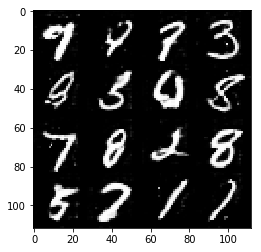

Epoch 5/5... Time Stamp 2017-07-30 19:26:29.479 Discriminator Loss: 0.8660... Generator Loss: 1.1454
Epoch 5/5... Time Stamp 2017-07-30 19:26:41.626 Discriminator Loss: 0.7288... Generator Loss: 1.3870
Epoch 5/5... Time Stamp 2017-07-30 19:26:53.733 Discriminator Loss: 0.6412... Generator Loss: 1.7085
Epoch 5/5... Time Stamp 2017-07-30 19:27:05.865 Discriminator Loss: 0.6314... Generator Loss: 1.7960
Epoch 5/5... Time Stamp 2017-07-30 19:27:18.018 Discriminator Loss: 0.8562... Generator Loss: 2.6044
Epoch 5/5... Time Stamp 2017-07-30 19:27:30.167 Discriminator Loss: 0.8319... Generator Loss: 1.2686
Epoch 5/5... Time Stamp 2017-07-30 19:27:42.303 Discriminator Loss: 1.0351... Generator Loss: 0.9086
Epoch 5/5... Time Stamp 2017-07-30 19:27:54.417 Discriminator Loss: 0.7175... Generator Loss: 1.5346
Epoch 5/5... Time Stamp 2017-07-30 19:28:06.599 Discriminator Loss: 1.3434... Generator Loss: 0.7520
Epoch 5/5... Time Stamp 2017-07-30 19:28:18.716 Discriminator Loss: 1.6160... Generator Los

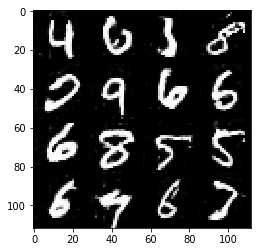

Epoch 5/5... Time Stamp 2017-07-30 19:28:31.419 Discriminator Loss: 0.7758... Generator Loss: 1.7229
Epoch 5/5... Time Stamp 2017-07-30 19:28:43.533 Discriminator Loss: 1.5877... Generator Loss: 2.9051
Epoch 5/5... Time Stamp 2017-07-30 19:28:55.624 Discriminator Loss: 1.2154... Generator Loss: 3.6101
Epoch 5/5... Time Stamp 2017-07-30 19:29:07.780 Discriminator Loss: 1.2641... Generator Loss: 0.6730
Epoch 5/5... Time Stamp 2017-07-30 19:29:19.917 Discriminator Loss: 0.7439... Generator Loss: 1.3566
Epoch 5/5... Time Stamp 2017-07-30 19:29:32.022 Discriminator Loss: 0.7010... Generator Loss: 1.5295
Epoch 5/5... Time Stamp 2017-07-30 19:29:44.144 Discriminator Loss: 1.1792... Generator Loss: 0.7150
Epoch 5/5... Time Stamp 2017-07-30 19:29:56.280 Discriminator Loss: 0.6331... Generator Loss: 2.5385
Epoch 5/5... Time Stamp 2017-07-30 19:30:08.506 Discriminator Loss: 0.6609... Generator Loss: 1.7599
Epoch 5/5... Time Stamp 2017-07-30 19:30:20.666 Discriminator Loss: 0.6783... Generator Los

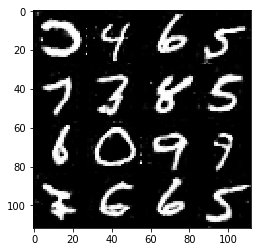

Epoch 5/5... Time Stamp 2017-07-30 19:30:33.363 Discriminator Loss: 0.7835... Generator Loss: 1.2488
Epoch 5/5... Time Stamp 2017-07-30 19:30:45.765 Discriminator Loss: 0.9308... Generator Loss: 1.3919
Epoch 5/5... Time Stamp 2017-07-30 19:30:58.126 Discriminator Loss: 1.7408... Generator Loss: 0.5024
Epoch 5/5... Time Stamp 2017-07-30 19:31:10.673 Discriminator Loss: 0.7157... Generator Loss: 2.0269
Epoch 5/5... Time Stamp 2017-07-30 19:31:23.186 Discriminator Loss: 0.5907... Generator Loss: 1.9684
Epoch 5/5... Time Stamp 2017-07-30 19:31:35.684 Discriminator Loss: 1.3512... Generator Loss: 0.6682
Epoch 5/5... Time Stamp 2017-07-30 19:31:48.187 Discriminator Loss: 1.7846... Generator Loss: 0.5007
Epoch 5/5... Time Stamp 2017-07-30 19:32:00.700 Discriminator Loss: 1.2897... Generator Loss: 3.6848
Epoch 5/5... Time Stamp 2017-07-30 19:32:13.160 Discriminator Loss: 0.6285... Generator Loss: 1.8960
Epoch 5/5... Time Stamp 2017-07-30 19:32:25.762 Discriminator Loss: 0.8045... Generator Los

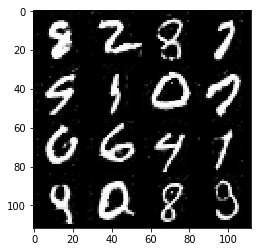

Epoch 5/5... Time Stamp 2017-07-30 19:32:39.021 Discriminator Loss: 1.4789... Generator Loss: 0.5845
Epoch 5/5... Time Stamp 2017-07-30 19:32:51.128 Discriminator Loss: 1.0292... Generator Loss: 0.9740
Epoch 5/5... Time Stamp 2017-07-30 19:33:03.245 Discriminator Loss: 1.2981... Generator Loss: 0.9470
Epoch 5/5... Time Stamp 2017-07-30 19:33:15.367 Discriminator Loss: 0.8966... Generator Loss: 1.2938
Epoch 5/5... Time Stamp 2017-07-30 19:33:27.605 Discriminator Loss: 1.7847... Generator Loss: 0.5184
Epoch 5/5... Time Stamp 2017-07-30 19:33:39.800 Discriminator Loss: 1.0565... Generator Loss: 0.9220
Epoch 5/5... Time Stamp 2017-07-30 19:33:52.168 Discriminator Loss: 0.7017... Generator Loss: 2.6244
Epoch 5/5... Time Stamp 2017-07-30 19:34:04.695 Discriminator Loss: 0.8665... Generator Loss: 1.2125
Epoch 5/5... Time Stamp 2017-07-30 19:34:17.190 Discriminator Loss: 0.7878... Generator Loss: 1.3673
Epoch 5/5... Time Stamp 2017-07-30 19:34:29.631 Discriminator Loss: 0.9334... Generator Los

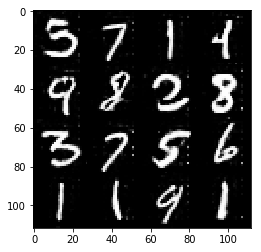

Epoch 5/5... Time Stamp 2017-07-30 19:34:42.878 Discriminator Loss: 1.6031... Generator Loss: 0.5283
Epoch 5/5... Time Stamp 2017-07-30 19:34:54.988 Discriminator Loss: 1.0266... Generator Loss: 0.9379
Epoch 5/5... Time Stamp 2017-07-30 19:35:07.116 Discriminator Loss: 0.7309... Generator Loss: 1.3342
Epoch 5/5... Time Stamp 2017-07-30 19:35:19.234 Discriminator Loss: 0.8461... Generator Loss: 1.1573
Epoch 5/5... Time Stamp 2017-07-30 19:35:31.358 Discriminator Loss: 0.9695... Generator Loss: 0.9929
Epoch 5/5... Time Stamp 2017-07-30 19:35:43.491 Discriminator Loss: 0.7318... Generator Loss: 2.1331
Epoch 5/5... Time Stamp 2017-07-30 19:35:55.619 Discriminator Loss: 0.9210... Generator Loss: 1.0922
Epoch 5/5... Time Stamp 2017-07-30 19:36:07.735 Discriminator Loss: 1.0429... Generator Loss: 1.0235
Epoch 5/5... Time Stamp 2017-07-30 19:36:19.906 Discriminator Loss: 0.5890... Generator Loss: 1.9188
Epoch 5/5... Time Stamp 2017-07-30 19:36:32.021 Discriminator Loss: 0.9760... Generator Los

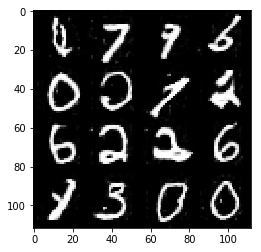

Epoch 5/5... Time Stamp 2017-07-30 19:36:44.853 Discriminator Loss: 0.8603... Generator Loss: 1.3015
Epoch 5/5... Time Stamp 2017-07-30 19:36:57.044 Discriminator Loss: 0.9410... Generator Loss: 1.0702
Epoch 5/5... Time Stamp 2017-07-30 19:37:09.569 Discriminator Loss: 0.8802... Generator Loss: 1.2521
Epoch 5/5... Time Stamp 2017-07-30 19:37:22.050 Discriminator Loss: 0.9955... Generator Loss: 1.0700
Epoch 5/5... Time Stamp 2017-07-30 19:37:34.515 Discriminator Loss: 1.5037... Generator Loss: 0.5684
Epoch 5/5... Time Stamp 2017-07-30 19:37:46.718 Discriminator Loss: 0.6605... Generator Loss: 1.5946
Epoch 5/5... Time Stamp 2017-07-30 19:37:58.898 Discriminator Loss: 1.2561... Generator Loss: 0.7034
Epoch 5/5... Time Stamp 2017-07-30 19:38:11.351 Discriminator Loss: 1.4049... Generator Loss: 0.6526
Epoch 5/5... Time Stamp 2017-07-30 19:38:23.816 Discriminator Loss: 1.0557... Generator Loss: 0.9647
Epoch 5/5... Time Stamp 2017-07-30 19:38:36.347 Discriminator Loss: 1.8368... Generator Los

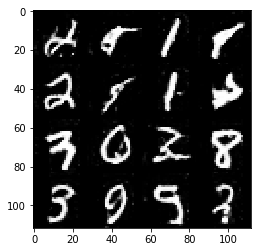

Epoch 5/5... Time Stamp 2017-07-30 19:38:49.168 Discriminator Loss: 1.6444... Generator Loss: 0.4714
Epoch 5/5... Time Stamp 2017-07-30 19:39:01.419 Discriminator Loss: 0.8815... Generator Loss: 1.1544
Epoch 5/5... Time Stamp 2017-07-30 19:39:13.919 Discriminator Loss: 0.6154... Generator Loss: 1.7731
Epoch 5/5... Time Stamp 2017-07-30 19:39:26.461 Discriminator Loss: 0.9258... Generator Loss: 1.1189
Epoch 5/5... Time Stamp 2017-07-30 19:39:38.970 Discriminator Loss: 0.7324... Generator Loss: 1.8331
Epoch 5/5... Time Stamp 2017-07-30 19:39:51.511 Discriminator Loss: 0.7934... Generator Loss: 1.2429
Epoch 5/5... Time Stamp 2017-07-30 19:40:03.985 Discriminator Loss: 0.6900... Generator Loss: 2.0936
Epoch 5/5... Time Stamp 2017-07-30 19:40:16.507 Discriminator Loss: 0.5899... Generator Loss: 1.8558
Epoch 5/5... Time Stamp 2017-07-30 19:40:28.687 Discriminator Loss: 0.9738... Generator Loss: 1.0870
Epoch 5/5... Time Stamp 2017-07-30 19:40:40.810 Discriminator Loss: 0.6174... Generator Los

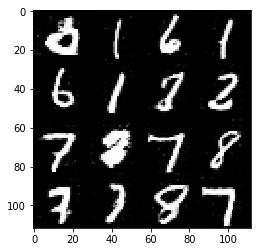

Epoch 5/5... Time Stamp 2017-07-30 19:40:53.423 Discriminator Loss: 0.8368... Generator Loss: 1.3066
Epoch 5/5... Time Stamp 2017-07-30 19:41:05.576 Discriminator Loss: 0.9359... Generator Loss: 1.0354
Epoch 5/5... Time Stamp 2017-07-30 19:41:17.777 Discriminator Loss: 0.6581... Generator Loss: 1.6198
Epoch 5/5... Time Stamp 2017-07-30 19:41:30.199 Discriminator Loss: 0.7618... Generator Loss: 1.6717
Epoch 5/5... Time Stamp 2017-07-30 19:41:42.686 Discriminator Loss: 1.2909... Generator Loss: 0.6497
Epoch 5/5... Time Stamp 2017-07-30 19:41:55.217 Discriminator Loss: 1.4410... Generator Loss: 0.6580
Epoch 5/5... Time Stamp 2017-07-30 19:42:07.581 Discriminator Loss: 0.8569... Generator Loss: 1.1882
Epoch 5/5... Time Stamp 2017-07-30 19:42:19.988 Discriminator Loss: 0.9190... Generator Loss: 1.1695
Epoch 5/5... Time Stamp 2017-07-30 19:42:32.536 Discriminator Loss: 0.7150... Generator Loss: 2.4301
Epoch 5/5... Time Stamp 2017-07-30 19:42:44.743 Discriminator Loss: 0.5526... Generator Los

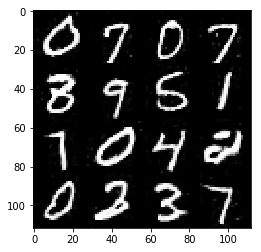

Epoch 5/5... Time Stamp 2017-07-30 19:42:57.367 Discriminator Loss: 0.6443... Generator Loss: 1.7534
Epoch 5/5... Time Stamp 2017-07-30 19:43:09.500 Discriminator Loss: 0.9152... Generator Loss: 1.1375
Epoch 5/5... Time Stamp 2017-07-30 19:43:21.636 Discriminator Loss: 0.7623... Generator Loss: 1.4018
Epoch 5/5... Time Stamp 2017-07-30 19:43:33.786 Discriminator Loss: 0.9464... Generator Loss: 3.1059
Epoch 5/5... Time Stamp 2017-07-30 19:43:45.923 Discriminator Loss: 0.9101... Generator Loss: 1.0585
Epoch 5/5... Time Stamp 2017-07-30 19:43:58.049 Discriminator Loss: 1.0252... Generator Loss: 0.9629
Epoch 5/5... Time Stamp 2017-07-30 19:44:10.158 Discriminator Loss: 1.5937... Generator Loss: 0.5485
Epoch 5/5... Time Stamp 2017-07-30 19:44:22.248 Discriminator Loss: 0.6619... Generator Loss: 2.9420


IndexError: list index out of range

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.